In [3]:
import pandas as pd
import numpy as np

In [14]:
"""
Script for checking the available resourses on the machine.
"""

import psutil
import GPUtil
import torch
import subprocess
import os


# Get CPU usage
cpu_percent = psutil.cpu_percent(percpu=True)
cpu_count = psutil.cpu_count(logical=True)

# Get RAM usage
ram_usage = psutil.virtual_memory()
ram_total = ram_usage.total / (1024 ** 3)  # Convert to GB
ram_available = ram_usage.available / (1024 ** 3)  # Convert to GB
ram_percent = ram_usage.percent

# Get GPU usage (if available)
gpus = GPUtil.getGPUs()
if gpus:
    for i, gpu in enumerate(gpus):
        gpu_ram_total = gpu.memoryTotal / 1024  # Convert to GB
        gpu_ram_used = gpu.memoryUsed / 1024  # Convert to GB
        gpu_ram_free = gpu.memoryFree / 1024  # Convert to GB
        gpu_ram_percent = gpu.memoryUsed / gpu.memoryTotal * 100
        print(f"GPU {i}:\n    RAM Total: {gpu_ram_total:.2f} GB\n    RAM Used: {gpu_ram_used:.2f} GB\n    RAM Free: {gpu_ram_free:.2f} GB\n    RAM Percent: {gpu_ram_percent:.2f}%\n    Load: {gpu.load * 100:.2f}%")
else:
    print("No GPUs found.")

# Print results for CPU and RAM usage
print(f"\nCPU usage: {cpu_percent}")
print(f"Number of CPU cores: {cpu_count}")
print(f"RAM usage: {ram_available:.2f} GB available out of {ram_total:.2f} GB ({ram_percent:.2f}%)")

# Get the disk usage information
usage_info = psutil.disk_usage('/')

# Print the used and available space
print(f"Disk usage: used {psutil._common.bytes2human(usage_info.used)}, available {psutil._common.bytes2human(usage_info.free)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nUsing device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    if torch.cuda.device_count() > 1:
        print(torch.cuda.get_device_name(1))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')
        print('Allocated:', round(torch.cuda.memory_allocated(1) / 1024 ** 3, 1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(1) / 1024 ** 3, 1), 'GB')
    else:
        print('Only one CUDA device is available.')



# Check if CUDA is available
if torch.cuda.is_available():

    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    
    # Get the device ID of the current CUDA device
    print("Selecting GPU_1 as the device")
    device = torch.device("cuda:1")

    device_id = torch.cuda.current_device()

    # Print the device ID
    print("Current CUDA device ID:", device_id)

    # Check if the selected device is gpu_1
    if device_id == 1:
        print("Selected device: gpu_1")
    else:
        print("Selected device: gpu_0")
else:
    print("CUDA is not available")

print("debugging\n")
print(torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i), i)

print(device_id)


# Check the size of the current user home directory
command = "du -sh /home/stefanos"
output = subprocess.check_output(command, shell=True, encoding="utf-8")
print("\nHome directory size:")
print(output)

GPU 0:
    RAM Total: 10.00 GB
    RAM Used: 1.35 GB
    RAM Free: 8.42 GB
    RAM Percent: 13.51%
    Load: 22.00%
GPU 1:
    RAM Total: 10.00 GB
    RAM Used: 0.34 GB
    RAM Free: 9.43 GB
    RAM Percent: 3.42%
    Load: 0.00%

CPU usage: [7.6, 9.9, 8.7, 6.9, 7.4, 6.3, 8.2, 5.9, 9.7, 5.1, 5.0, 6.6, 4.6, 4.5, 4.2, 51.8]
Number of CPU cores: 16
RAM usage: 46.37 GB available out of 62.79 GB (26.20%)
Disk usage: used 337.3G, available 126.8G

Using device: cuda
NVIDIA GeForce RTX 3080
NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
Allocated: 0.0 GB
Cached:    0.0 GB
Selecting GPU_1 as the device
Current CUDA device ID: 0
Selected device: gpu_0
debugging

2
NVIDIA GeForce RTX 3080 0
NVIDIA GeForce RTX 3080 1
0

Home directory size:
103G	/home/stefanos



In [22]:
import math
import typing as ty
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

import lib


# ... (Rest of your code, including the MLP class definition) ...

# Load the checkpoint
checkpoint = torch.load('/home/stefanos/PasterQuality/src/experiments/revisiting_models/output_pasterquality/tabular_split_3/mlp/tuned/0/checkpoint.pt')

# Create your model instance using the architecture and configuration used during training
model = MLP().to(device)

# Load the model's state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

# New instance to predict (example input)
new_instance = torch.tensor(torch.tensor(X_val.values), dtype=torch.float32)  # Adjust the input data

# Make a prediction
with torch.no_grad():
    predictions = model(new_instance)

# The 'predictions' tensor contains the model's output for the new instance
print(predictions)

TypeError: __init__() missing 6 required keyword-only arguments: 'd_in', 'd_layers', 'dropout', 'd_out', 'categories', and 'd_embedding'

In [24]:
checkpoint['model_state_dict']

KeyError: 'model_state_dict'

In [21]:
class MLP(nn.Module):
    def __init__(
        self,
        *,
        d_in: int,
        d_layers: ty.List[int],
        dropout: float,
        d_out: int,
        categories: ty.Optional[ty.List[int]],
        d_embedding: int,
    ) -> None:
        super().__init__()

        if categories is not None:
            d_in += len(categories) * d_embedding
            category_offsets = torch.tensor([0] + categories[:-1]).cumsum(0)
            self.register_buffer('category_offsets', category_offsets)
            self.category_embeddings = nn.Embedding(sum(categories), d_embedding)
            nn.init.kaiming_uniform_(self.category_embeddings.weight, a=math.sqrt(5))
            print(f'{self.category_embeddings.weight.shape=}')

        self.layers = nn.ModuleList(
            [
                nn.Linear(d_layers[i - 1] if i else d_in, x)
                for i, x in enumerate(d_layers)
            ]
        )
        self.dropout = dropout
        self.head = nn.Linear(d_layers[-1] if d_layers else d_in, d_out)

    def forward(self, x_num, x_cat):
        x = []
        if x_num is not None:
            x.append(x_num)
        if x_cat is not None:
            x.append(
                self.category_embeddings(x_cat + self.category_offsets[None]).view(
                    x_cat.size(0), -1
                )
            )
        x = torch.cat(x, dim=-1)

        for layer in self.layers:
            x = layer(x)
            x = F.relu(x)
            if self.dropout:
                x = F.dropout(x, self.dropout, self.training)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

In [10]:
# Load saved models to predict..

from catboost import CatBoost

# Specify the path to the saved model file (.cbm)
model_path = '/home/stefanos/PasterQuality/src/experiments/revisiting_models/output_pasterquality/tabular_split_0/catboost_/tuned/0/model.cbm'

# Load the model
model = CatBoost()
model.load_model(model_path)

model.predict

In [11]:
X_val = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_4/X_val.csv')

In [13]:
model.predict(X_val)

array([-0.48368619,  0.40493147, -0.50929665,  0.16383725,  0.01339699,
       -0.49143002,  0.19062873, -0.29928076, -0.84552098, -0.48428062,
        0.11428003,  0.74002523, -0.43544787, -0.13783638, -0.45431024,
       -0.75767399, -0.82517107,  0.17569929,  0.50931782,  2.14209751,
        0.81958234, -0.67432716, -0.3908223 , -0.32479064,  0.58509513,
        0.30134434,  0.22890581,  0.45486736, -0.16679191, -0.19679334,
       -0.41122722, -0.83525817, -0.07749114, -0.65180353,  0.74880304,
        0.26961998, -0.63231524,  0.12874287, -0.10865291, -0.70970385,
       -0.42850699,  1.0462584 ,  0.12111532, -0.63732301,  0.15225681,
       -0.4564774 ,  0.71971702, -0.3951463 , -0.66868622,  1.63617785,
       -0.44734727,  0.08062978,  0.17586845, -0.51162175,  0.00708958,
       -0.06639934, -0.38616619, -0.12838892,  0.22312115,  0.76310415,
       -0.44099311,  0.51915656, -0.04149377, -0.76458345, -0.14839463,
       -0.45501001])

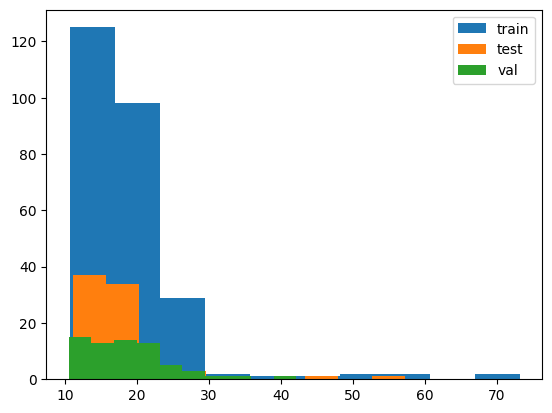

In [4]:
y_train = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_4/y_train.csv')
y_test = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_4/y_test.csv')
y_val = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_4/y_val.csv')

#plot histograms and show that the data is not balanced
import matplotlib.pyplot as plt
plt.hist(y_train['PU'], label='train')
plt.hist(y_test['PU'], label='test')
plt.hist(y_val['PU'], label='val')
plt.legend()

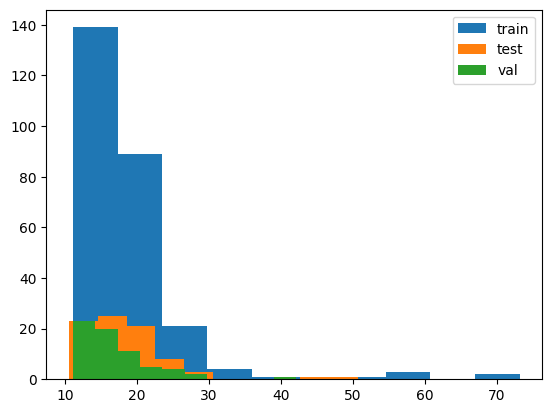

In [5]:
y_train = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_3/y_train.csv')
y_test = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_3/y_test.csv')
y_val = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_3/y_val.csv')

#plot histograms and show that the data is not balanced
import matplotlib.pyplot as plt
plt.hist(y_train['PU'], label='train')
plt.hist(y_test['PU'], label='test')
plt.hist(y_val['PU'], label='val')
plt.legend()

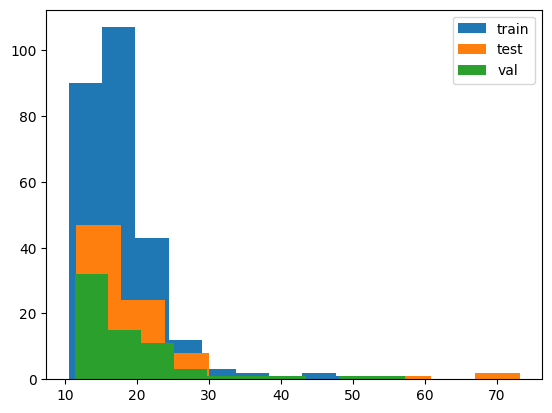

In [6]:
y_train = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_2/y_train.csv')
y_test = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_2/y_test.csv')
y_val = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_2/y_val.csv')

#plot histograms and show that the data is not balanced
import matplotlib.pyplot as plt
plt.hist(y_train['PU'], label='train')
plt.hist(y_test['PU'], label='test')
plt.hist(y_val['PU'], label='val')
plt.legend()

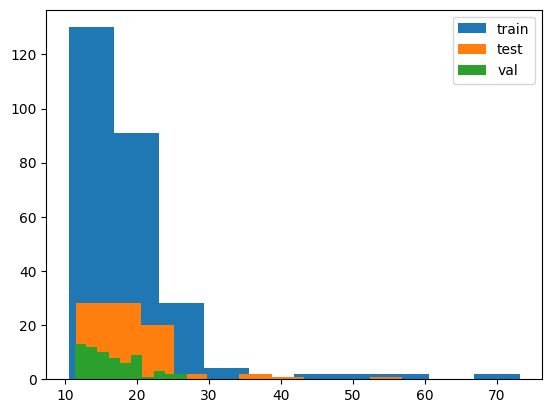

In [7]:

y_train = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_1/y_train.csv')
y_test = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_1/y_test.csv')
y_val = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_1/y_val.csv')

#plot histograms and show that the data is not balanced
import matplotlib.pyplot as plt
plt.hist(y_train['PU'], label='train')
plt.hist(y_test['PU'], label='test')
plt.hist(y_val['PU'], label='val')
plt.legend()

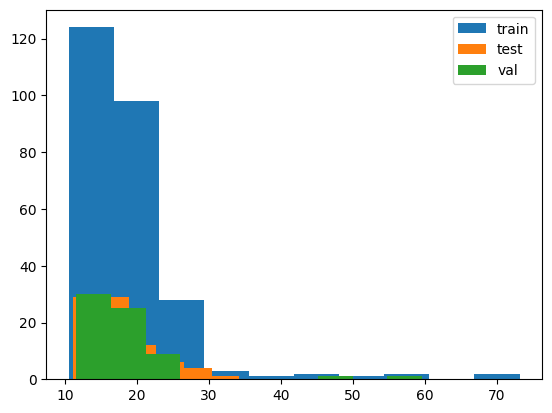

In [8]:
y_train = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_0/y_train.csv')
y_test = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_0/y_test.csv')
y_val = pd.read_csv('/home/stefanos/PasterQuality/data/tabular/csv/split_0/y_val.csv')

#plot histograms and show that the data is not balanced
import matplotlib.pyplot as plt
plt.hist(y_train['PU'], label='train')
plt.hist(y_test['PU'], label='test')
plt.hist(y_val['PU'], label='val')
plt.legend()